# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Chapter 6 Project: Sign language exercise

---
### 1. Import the libraries that we need

In [1]:
#random seed 고정
import random
import torch
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
# DEVICE 초기화
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"DEVICE:{DEVICE}")


# model summary
%pip install torchsummary ## model을 요약하기 위해 torchsummary 설치
from torchsummary import summary as summary_## 모델 정보를 확인하기 위해 torchsummary 함수 import

## 모델의 형태를 출력하기 위한 함수 
def summary_model(model,input_shape=(3, 32, 32)):
    model = model.cuda()
    summary_(model, input_shape) ## (model, (input shape))


DEVICE:cuda
Note: you may need to restart the kernel to use updated packages.


### 2. Data preparation

In [3]:
train_path  = '/kaggle/input/2023-1-DLS-W6P2/train'
valid_path  = '/kaggle/input/2023-1-DLS-W6P2/valid'
test_path  = '/kaggle/input/2023-1-DLS-W6P2/test'

In [4]:
from torchvision.models import VGG16_Weights ## 사전학습된 VGG16를 이용하기 위해 import

transform_ = VGG16_Weights.DEFAULT.transforms() ## VGG16에서 사용한 transform을 이용
transform_.resize_size=[224] ## resize 크기는 224가 되도록 설정
print(transform_)  ## transform 확인하기

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
## Torchvision의 함수를 이용하여 로더 작성하기
import torch.nn as nn 
import torchvision

## Torchvision의 함수를 이용하여 로더 작성하기
## https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html 
trainSet = torchvision.datasets.ImageFolder(root = train_path,
                                            transform = transform_)
validSet = torchvision.datasets.ImageFolder(root = valid_path,
                                            transform = transform_)
testSet = torchvision.datasets.ImageFolder(root = test_path,
                                            transform = transform_)

## loader
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=10, shuffle=True)
validloader = torch.utils.data.DataLoader(validSet, batch_size=30, shuffle=False)
testloader = torch.utils.data.DataLoader(testSet, batch_size=50, shuffle=False)


In [6]:
images, labels = next(iter(trainloader))
print("image shape:", images.shape)
print("label shape:", labels.shape)

image shape: torch.Size([10, 3, 224, 224])
label shape: torch.Size([10])


### 3. VGG16 base model pre-trained on ImageNet dataset

In [7]:
from torchvision.models import VGG16_Weights
## Classifier 부분은 제외하고 가져오기
base_model = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
## 마지막에 global_avg_pool2d 추가하기
base_model.global_avg_pool2d = nn.AdaptiveAvgPool2d((1,1))
print(base_model)
summary_model(base_model, (3,224,224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### 2. freeze the classification layers in the base model

In [8]:
## 모델의 뒷단만 학습하도록 하기 위해서 앞부분은 freeze 해주기

for para in base_model[:-10].parameters(): ## keras는 -5이고 pytorch에서는 -10인 이유는 keras는 layer를 설정할 때 활성화함수까지 포함하기 때문..
    para.requires_grad = False

summary_model(base_model,(3,224,224)) ## 모델 요약 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
## Classifier 만들기
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,10), ## 512, 7, 7
    # nn.Softmax() ## CrossEntropy에 Softmax가 포함되므로 사용하지 않음
)

base_model.classifier = classifier ## 모델에 classifier라는 이름으로 추가
print(base_model)
summary_model(base_model, (3,224,224))## 모델 요약 정보 확인

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### 4. Train the new model

In [10]:
# 모델 학습하기
import time

# 파라미터 설정
total_epoch = 15
best_loss = 100 ## loss를 기준으로 best_checkpoint를 저장하기 위해 100으로 설정하였음.

lr_rate = 0.0001
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr_rate)## Adma을 최적화 함수로 이용함. 파라미터는 documentation을 참조!

loss = torch.nn.CrossEntropyLoss().cuda()## 분류문제이므로 CrossEntropyLoss를 이용함

## 모델 시각화를 위해 정확도를 저장할 리스트 생성
train_accuracys=[]
eval_accuracys=[]

for epoch in range(total_epoch):
    start = time.time()
    print(f'Epoch {epoch}/{total_epoch}')

    # train
    train_loss = 0
    correct = 0
    for x, target in trainloader:## 한번에 배치사이즈만큼 데이터를 불러와 모델을 학습함

        optimizer.zero_grad()## 이전 loss를 누적하지 않기 위해 0으로 설정해주는 과정
        
        y_pred = base_model(x.cuda())## 모델의 출력값
        
        cost = loss(y_pred, target.cuda())## loss 함수를 이용하여 오차를 계산함

        cost.backward() # gradient 구하기 
        optimizer.step()# 모델 학습
        train_loss += cost.item()
        
        pred = y_pred.data.max(1, keepdim=True)[1] ## 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
        correct += pred.cpu().eq(target.data.view_as(pred)).sum() # pred와 target을 비교하여 맞은 개수를 구하는 과정.
                                                                  # view_as함수는 들어가는 인수의 모양으로 맞춰주고, .eq()를 통해 pred와 target의 값이 동일한지 판단하여 True 개수 구하기
    
    train_loss /= len(trainloader)
        
    train_accuracy = correct / len(trainloader.dataset)
    train_accuracys.append(train_accuracy) ## 그래프로 표현하기 위해 리스트에 담음

    
    #Evaluate
    eval_loss = 0
    correct = 0
    with torch.no_grad(): ## 학습하지 않기 위해
        base_model.eval()# 평가 모드로 변경
        for x, target in validloader:
            y_pred = base_model(x.cuda())## 모델의 출력값
            cost = loss(y_pred, target.cuda())## loss 함수를 이용하여 valid 데이터의 오차를 계산함
            eval_loss += cost
            
            pred = y_pred.data.max(1, keepdim=True)[1]## 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
            correct += pred.cpu().eq(target.data.view_as(pred)).cpu().sum()# pred와 target을 비교하여 맞은 개수를 구하는 과정
            
        eval_loss /= len(validloader)
        eval_accuracy = correct / len(validloader.dataset)
        eval_accuracys.append(eval_accuracy)## 그래프로 표현하기 위해 리스트에 담음
        
        ## valid 데이터의 loss를 기준으로 이전 loss 보다 작을 경우 체크포인트 저장
        if eval_loss < best_loss:
            torch.save({
                'epoch': epoch,
                'model': base_model,
                'model_state_dict': base_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': cost.item,
                }, './bestCheckPoint.pth')
            
            print(f'Epoch {epoch:05d}: val_loss improved from {best_loss:.5f} to {eval_loss:.5f}, saving model to bestCheckPiont_resnet50.pth')
            best_loss = eval_loss
        else:
            print(f'Epoch {epoch:05d}: val_loss did not improve')
        base_model.train()
        
    print(f'{int(time.time() - start)}s - loss: {train_loss:.5f} - acc: {train_accuracy:.5f} - val_loss: {eval_loss:.5f} - val_acc: {eval_accuracy:.5f}')

Epoch 0/15
Epoch 00000: val_loss improved from 100.00000 to 0.10571, saving model to bestCheckPiont_resnet50.pth
24s - loss: 0.68269 - acc: 0.78972 - val_loss: 0.10571 - val_acc: 0.98000
Epoch 1/15
Epoch 00001: val_loss improved from 0.10571 to 0.09374, saving model to bestCheckPiont_resnet50.pth
18s - loss: 0.05270 - acc: 0.98715 - val_loss: 0.09374 - val_acc: 0.98667
Epoch 2/15
Epoch 00002: val_loss improved from 0.09374 to 0.08191, saving model to bestCheckPiont_resnet50.pth
18s - loss: 0.02272 - acc: 0.99650 - val_loss: 0.08191 - val_acc: 0.99000
Epoch 3/15
Epoch 00003: val_loss improved from 0.08191 to 0.07792, saving model to bestCheckPiont_resnet50.pth
18s - loss: 0.00296 - acc: 1.00000 - val_loss: 0.07792 - val_acc: 0.99000
Epoch 4/15
Epoch 00004: val_loss did not improve
18s - loss: 0.00101 - acc: 1.00000 - val_loss: 0.08324 - val_acc: 0.99000
Epoch 5/15
Epoch 00005: val_loss did not improve
18s - loss: 0.00065 - acc: 1.00000 - val_loss: 0.08466 - val_acc: 0.99000
Epoch 6/15
E

### 5. create the confusion matrix to evaluate the model

In [11]:
## 저장되어있는 best 체크포인트 load하기
best_model = torch.load('./bestCheckPoint.pth')['model']  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
best_model.load_state_dict(torch.load('./bestCheckPoint.pth')['model_state_dict'])  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [12]:
#prediction

correct = 0
total = 0
pred_ = []

with torch.no_grad(): ## 학습하지 않기 위해
    best_model.eval()
    for data, label in testloader:
        print(data.shape)
        outputs = best_model(data.cuda())
        _, predicted = torch.max(outputs.data, 1)
        pred_.append(predicted.cpu()) ## 제출을 위해 예측값을 pred_로 받아줌
        total += label.size(0)
        correct += (predicted == label.cuda()).sum().item()
        
print('Test accuracy: %d %%' % (100 * correct / total))

torch.Size([50, 3, 224, 224])
Test accuracy: 100 %


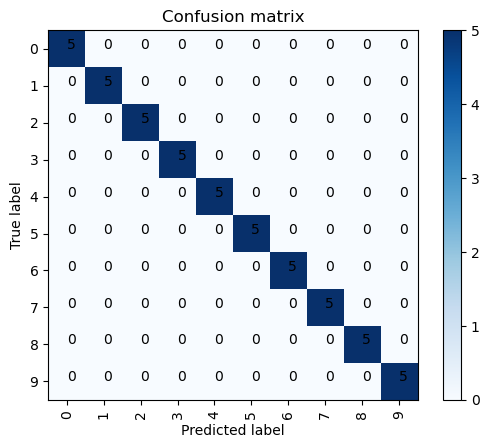

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cm_labels = ['0','1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(testSet.targets,
                      np.array(pred_[0].cpu()))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

### The End!

In [14]:
## pandas를 이용하여 sample.csv 파일 읽기
import pandas as pd

sample = pd.read_csv("/kaggle/input/2023-1-DLS-W6P2/sample.csv")
sample.head()

,ID,label
0,IMG_4159,0
1,IMG_4725,0
2,IMG_4976,0
3,IMG_5572,0
4,IMG_5695,0


In [15]:
pred_, np.array(pred_[0].cpu())

([tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
          4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
          9, 9])],
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
        8, 9, 9, 9, 9, 9]))

In [16]:
result = np.array(pred_[0])

In [17]:
for i, info in enumerate(testloader.dataset.imgs):
    path = info[0]
    id = (path.split("/")[-1]).split(".")[-2] ## test 이미지의 ID를 찾는 방법 
    sample['label'][sample['ID']== id]= result[i] ## sample의 ID에 맞추어 예측값 넣기

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
## csv 파일로 저장
sample.to_csv("baseline.csv",index=False,header=True)

In [19]:
sample

,ID,label
0,IMG_4159,0
1,IMG_4725,0
2,IMG_4976,0
3,IMG_5572,0
4,IMG_5695,0
5,IMG_4497,1
6,IMG_5309,1
7,IMG_5340,1
8,IMG_5401,1
9,IMG_5992,1
